### Test the trained network

In [1]:
from keras.layers import Input, Dense, Activation, Lambda, Dropout, Concatenate, Reshape
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, Callback
from keras import optimizers
from keras import backend as K

import tensorflow as tf

from keras.regularizers import l2


### Hyperparameters
batch_size = 1 
k = 2
d = 4


/Users/jyotirmaysenapati/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


- Network to load

In [2]:
timestamp = "2018-07-28_17:12"

epoch = 10000

- Load gmm params

In [3]:
import numpy as np

In [4]:
filename=timestamp + "-gmmParams.npz"

with np.load(filename) as data:
    phi = data["phi"]
    mu = data["mu"]
    sigma = data["sigma"]
    

In [5]:
phi = K.constant(phi)
mu = K.constant(mu)
sigma = K.constant(sigma)

In [6]:
K.eval(phi)

array([0.5, 0.5], dtype=float32)

In [7]:
K.eval(mu)

array([[0.75538546, 0.75538546, 0.75538546, 0.75538546],
       [0.75538546, 0.75538546, 0.75538546, 0.75538546]], dtype=float32)

In [8]:
K.eval(sigma)

array([[[ 1.9578843 , -2.3390892 ,  0.1336104 , -0.33108056],
        [-2.3390892 ,  7.3980327 , -0.5650078 ,  1.4113652 ],
        [ 0.1336104 , -0.5650078 ,  0.05031497, -0.12633346],
        [-0.33108056,  1.4113652 , -0.12633346,  0.31788355]],

       [[ 1.9578843 , -2.3390892 ,  0.1336104 , -0.33108056],
        [-2.3390892 ,  7.3980327 , -0.5650078 ,  1.4113652 ],
        [ 0.1336104 , -0.5650078 ,  0.05031497, -0.12633346],
        [-0.33108056,  1.4113652 , -0.12633346,  0.31788355]]],
      dtype=float32)

- Plot loss history

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

In [11]:
def plotHistory(loss_array, save=False, savename=timestamp+"-lossGraph.png"):
    fig = plt.figure()
    ax = fig.add_subplot(111)    # The big subplot
    ax.set_title("Loss graph for end-to-end training")

    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax.plot(loss_array)
    
    if save:
        plt.savefig(savename)

In [12]:
filename = timestamp + "-history.npz"
with np.load(filename) as data:
    history = data["history"]

history = history.ravel()[0]["loss"]

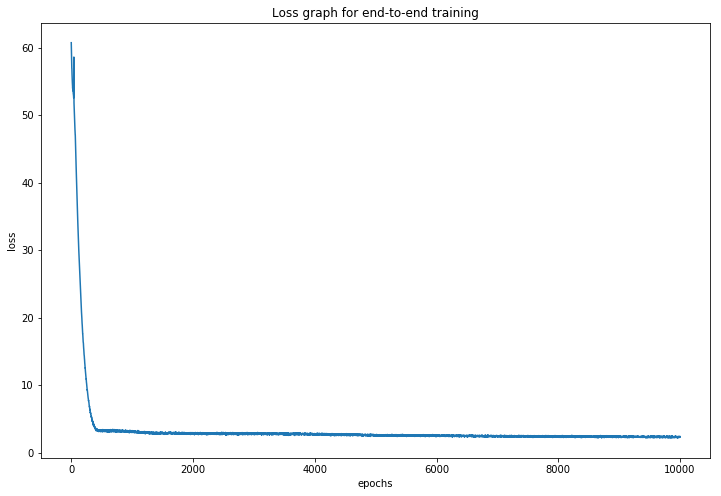

In [13]:
plotHistory(history, save=True)

- Network definition for testing

In [14]:
### Define compresion network

input_data = Input(batch_shape=(batch_size,279), name='input_placeholder')

encoded = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(input_data)

layer_lowdim = Dense(2, activation='linear', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(encoded)

decoded = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(layer_lowdim)
decoded = Dense(279, activation='linear', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(decoded)





### Define similarity metrics

def cos_sim(a_b):
    '''
    a: batch x 120
    b: batch x 120 
    
    output: batch x 1
    '''
    a, b = a_b
    
    norm_a = K.sqrt(K.sum(a ** 2, axis=-1))
    norm_b = K.sqrt(K.sum(b ** 2, axis=-1))
    
    out = K.sum(a * b, axis=-1) / (norm_a * norm_b)
    out = K.reshape(out, [batch_size, 1])
    
    return out

def relative_euc_dist(a_b):
    '''
    a: batch x 120
    b: batch x 120 
    
    output: batch x 1
    '''
    a,b = a_b
    
    norm_diff = K.sqrt(K.sum((a - b)**2, axis=-1))
    norm_a = K.sqrt(K.sum(a ** 2, axis=-1))
    
    out = norm_diff / norm_a
    out = K.reshape(out, [batch_size, 1])

    return out

layer_cossim = Lambda(cos_sim,
                      name='cos_sim')([input_data, decoded])

layer_relativeEuc = Lambda(relative_euc_dist, 
                           name='relative_euc_dist')([input_data, decoded])

### Obtain "z"
def funct_concat(tensors):
    return K.concatenate(tensors)

layer_concat = Lambda(funct_concat, name="z")([layer_lowdim, layer_cossim, layer_relativeEuc])


### Sample energy as a lambda function at the end
def computeEnergy(z_i):
    inside_sum = tf.zeros(()) 
    for cluster in range(k):
        diff = tf.reshape(z_i - mu[cluster], (1,-1))   ### (1,3)
        diff_t = tf.reshape(diff, (-1,1)) #diff.reshape(-1,1)   ### (3,1)

        sigma_inv = tf.linalg.inv(sigma[cluster]) ### (3,3)
        
        exp_term = tf.exp(-0.5 * tf.matmul(diff, tf.matmul(sigma_inv, diff_t)))    ### (1,1)

        denom = tf.sqrt(tf.linalg.det(2 * np.pi * sigma[cluster]))
        
        inside_sum += phi[cluster] * (exp_term / denom)   ### (1,1)
        
        
    inside_sum = tf.reshape(inside_sum, ())
    
    sample_energy = -tf.log(inside_sum + 1e-6) 
    
    
    return sample_energy

def energyCalc(yTrue, yPred):
    
    z = layer_concat

    return computeEnergy(z)


layer_energy = Lambda(computeEnergy,
                      name='sample_energy')([layer_concat])




eval_net = Model(input=input_data, outputs=layer_energy)

eval_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_placeholder (InputLayer)  (1, 279)             0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (1, 10)              2800        input_placeholder[0][0]          
__________________________________________________________________________________________________
dense_2 (Dense)                 (1, 2)               22          dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (1, 10)              30          dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

/Users/jyotirmaysenapati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:101: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("sa..., inputs=Tensor("in...)`


- Load trained weights

In [15]:
filename = timestamp + "-modelsave_weights-epochs{}.h5".format(epoch)
eval_net.load_weights(filename, by_name=True)

- Load dataset

In [16]:
import numpy as np

In [17]:
with np.load('arythmia_test-randomState_None.npz') as data:  ### kdd99_test
    x_test = data['x_test']
#     x_test = x_test[:, 0:6]

print(x_test)
# print(y_test)

[[0.46987952 1.         0.07407407 ... 0.59482201 0.         1.        ]
 [0.38554217 0.         0.10074074 ... 0.53203883 0.         1.        ]
 [0.55421687 0.         0.09333333 ... 0.46148867 0.         1.        ]
 ...
 [0.62650602 1.         0.07407407 ... 0.46019417 0.         1.        ]
 [0.57831325 0.         0.10814815 ... 0.34368932 1.         0.        ]
 [0.69879518 0.         0.08148148 ... 0.29190939 0.         1.        ]]


In [18]:
normal_data = x_test[np.where(x_test[:,-1] == 1)]

In [19]:
anomaly_data = x_test[np.where(x_test[:,-1] == 0)]

In [20]:
normal_data = normal_data[:, 0:279]
normal_data.shape

(192, 279)

In [53]:
anomaly_data = anomaly_data[:, 0:279]
anomaly_data.shape

anomaly_percentage = anomaly_data.shape[0]/(anomaly_data.shape[0]+normal_data.shape[0])
print(anomaly_data.shape, anomaly_percentage)

34 0.1504424778761062


### Obtain sample energies

- Energies from normal class

In [22]:
energies_normal = eval_net.predict(normal_data, batch_size=1, verbose=1)  

192/192 [==============================] - 0s 888us/step


In [23]:
energies_normal

array([ 3.67125320e+00, -3.95089686e-01,  2.05923700e+00,  4.42252576e-01,
       -4.81631696e-01,  5.47323786e-02,  4.33185875e-01, -4.76905316e-01,
        1.46190989e+00,  1.05255112e-01, -6.53972745e-01, -6.46684945e-01,
       -2.66617447e-01, -1.20610915e-01, -5.39465368e-01,  1.27400434e+00,
        6.09293431e-02, -2.07173020e-01, -4.91608083e-01, -7.61377692e-01,
       -4.84145641e-01, -6.50329471e-01, -4.93351400e-01,  5.42146981e-01,
        4.22745682e-02, -1.35732412e-01, -9.81648088e-01, -6.19912028e-01,
       -6.00061774e-01, -5.83917022e-01, -5.54046988e-01,  2.36358240e-01,
        5.47203302e+00,  3.77817787e-02,  1.25037134e+00,  1.66960871e+00,
       -6.25415683e-01,  6.29691315e+00, -5.15800476e-01, -5.63729882e-01,
        9.73777846e-02, -9.61212873e-01,  7.35092163e-01,  1.27484277e-01,
       -4.35573101e-01,  4.20289850e+00,  7.07266256e-02, -7.45516479e-01,
       -1.93722412e-01, -6.90195382e-01,  1.95549560e+00,  1.52140605e+00,
       -2.26652816e-01, -

In [24]:
energies_normal.min()

-0.9816481

In [25]:
energies_normal.max()

13.728243

In [26]:
hist_bins = 500

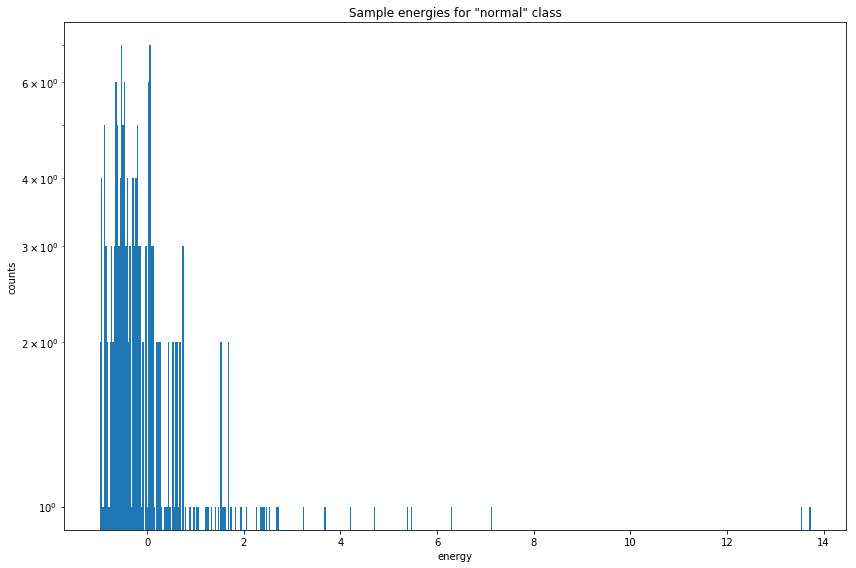

In [27]:
plt.hist(energies_normal, bins=hist_bins, log=True)

plt.title("Sample energies for \"normal\" class")
plt.xlabel("energy")
plt.ylabel("counts")
plt.tight_layout()

filename = timestamp + "-normalHist_bins{}.png".format(hist_bins)
plt.savefig(filename)

- Energies from anomaly class

In [28]:

energies_anomaly = eval_net.predict(anomaly_data, batch_size=1, verbose=1)  

34/34 [==============================] - 0s 877us/step


In [29]:
energies_anomaly

array([ 4.2744362e-01, -7.1872580e-01,  3.2356238e+00,  6.4205271e-01,
       -4.8112214e-02,  1.6053953e+00, -6.1947558e-02,  9.8565025e+00,
        1.1304072e+00,  2.7132685e+00, -3.2226428e-02,  1.0955198e+01,
       -6.3213575e-01,  7.0946679e+00,  3.4294150e+00,  3.9178710e+00,
        1.5096803e+00,  2.3395135e+00,  8.5569397e-02,  4.5743527e+00,
        1.2630391e+00,  7.8784995e-02,  1.8425736e+00, -2.8109890e-01,
        7.0562925e+00,  1.8976872e+00,  4.1320925e+00,  2.5558171e-01,
       -7.9683037e-03,  3.4228461e+00,  1.1211581e+01,  1.7546215e+00,
        2.2134757e+00, -4.8050636e-01], dtype=float32)

In [30]:
energies_anomaly.min()

-0.7187258

In [31]:
energies_anomaly.max()

11.211581

In [32]:
plt.hist?

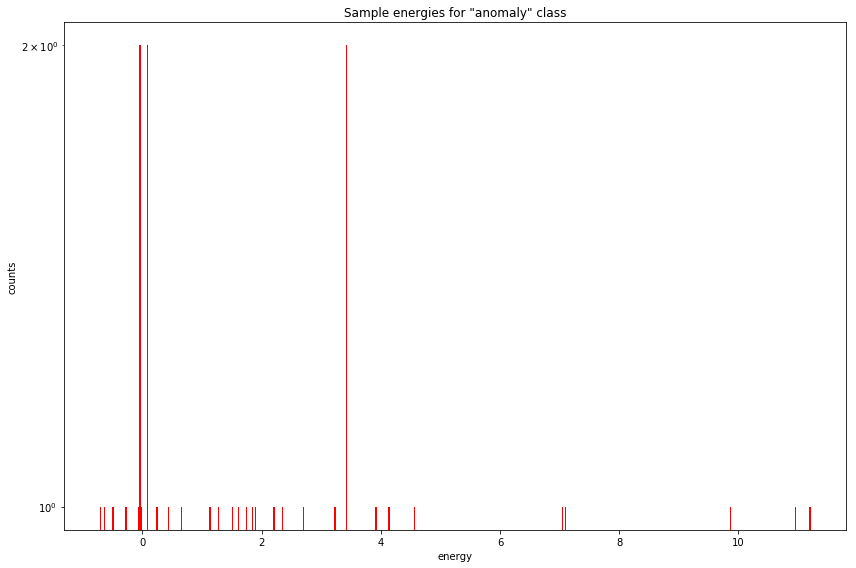

In [33]:
plt.hist(energies_anomaly, bins=hist_bins, color="red", log=True)

plt.title("Sample energies for \"anomaly\" class")
plt.xlabel("energy")
plt.ylabel("counts")
plt.tight_layout()

filename = timestamp + "-anomalyHist_bins{}.png".format(hist_bins)
plt.savefig(filename)

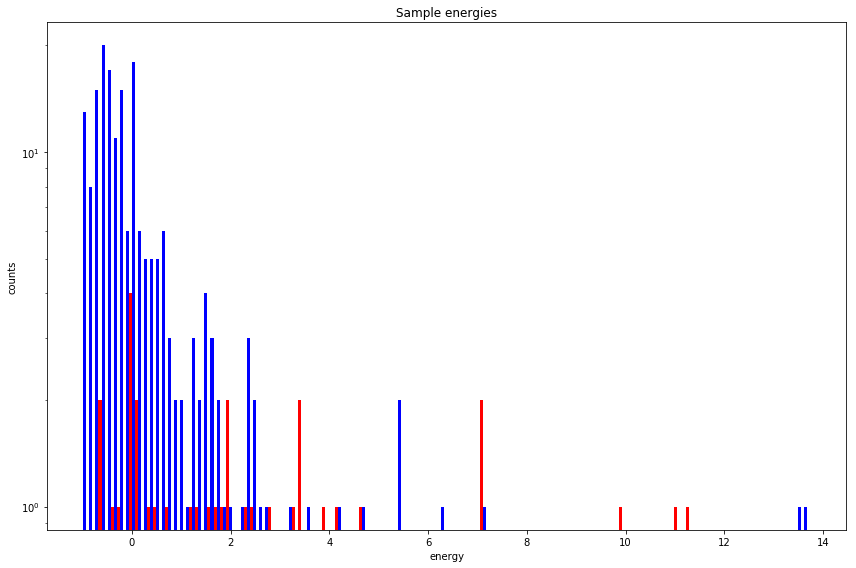

In [34]:
hist_bins = 120

plt.hist((energies_normal, energies_anomaly), 
         bins=hist_bins, 
         color=["blue", "red"], 
         histtype="bar", 
         label=["normal", "anomaly"], 
         rwidth=1.0,
         stacked=False,
         log=True)

plt.title("Sample energies")
plt.xlabel("energy")
plt.ylabel("counts")
plt.tight_layout()

filename = timestamp + "-allHist_bins{}.png".format(hist_bins)
plt.savefig(filename)


### Find the threshold for classifying as anomaly: "top %20 of highest energy"

In [35]:
energies_all = np.concatenate((energies_normal, energies_anomaly), axis=0)

In [36]:
energies_all.shape

(226,)

- Sort calculated energies descending

In [37]:
sorted_energies = np.sort(energies_all)[::-1]

In [38]:
sorted_energies

array([ 1.37282429e+01,  1.35495958e+01,  1.12115812e+01,  1.09551983e+01,
        9.85650253e+00,  7.11091280e+00,  7.09466791e+00,  7.05629253e+00,
        6.29691315e+00,  5.47203302e+00,  5.39568424e+00,  4.71190214e+00,
        4.57435274e+00,  4.20289850e+00,  4.13209248e+00,  3.91787100e+00,
        3.67125320e+00,  3.42941499e+00,  3.42284608e+00,  3.25422764e+00,
        3.23562384e+00,  2.71326852e+00,  2.70949221e+00,  2.68705630e+00,
        2.52524209e+00,  2.47345901e+00,  2.41105986e+00,  2.39767528e+00,
        2.35751176e+00,  2.33951354e+00,  2.26513672e+00,  2.21347570e+00,
        2.05923700e+00,  1.95549560e+00,  1.89768720e+00,  1.84257364e+00,
        1.81525683e+00,  1.75462151e+00,  1.73802006e+00,  1.68788767e+00,
        1.66960871e+00,  1.61907470e+00,  1.60539532e+00,  1.58695698e+00,
        1.57526171e+00,  1.52140605e+00,  1.52043664e+00,  1.50968027e+00,
        1.46190989e+00,  1.43035579e+00,  1.32080472e+00,  1.27400434e+00,
        1.26303911e+00,  

- Top %20 percent is the first %20 part of it

In [54]:
 

threshold_index = int(np.floor(len(sorted_energies) * anomaly_percentage))


In [55]:
sorted_energies[:threshold_index]

array([13.728243 , 13.549596 , 11.211581 , 10.955198 ,  9.856503 ,
        7.110913 ,  7.094668 ,  7.0562925,  6.296913 ,  5.472033 ,
        5.3956842,  4.711902 ,  4.5743527,  4.2028985,  4.1320925,
        3.917871 ,  3.6712532,  3.429415 ,  3.422846 ,  3.2542276,
        3.2356238,  2.7132685,  2.7094922,  2.6870563,  2.525242 ,
        2.473459 ,  2.4110599,  2.3976753,  2.3575118,  2.3395135,
        2.2651367,  2.2134757,  2.059237 ,  1.9554956], dtype=float32)

In [56]:
threshold = sorted_energies[threshold_index]

- Below this threshold, samples are classified as normal

In [57]:
threshold

1.8976872

### Calculate metrics

- "Anomaly class is positive" (from paper)

|                   | anomaly | normal |   |   |
|-------------------|---------|--------|---|---|
| predicted anomaly | TP      | FP     |   |   |
| predicted normal  | FN      | TN     |   |   |
|                   |         |        |   |   |

In [58]:
tp = len(energies_anomaly[energies_anomaly >= threshold])
fp = len(energies_normal[energies_normal > threshold])

tn = len(energies_normal[energies_normal <= threshold])
fn = len(energies_anomaly[energies_anomaly < threshold])

print(tp, fp, tn, fn)

15 20 172 19


In [59]:
precision = tp / (tp + fp)

In [60]:
precision

0.42857142857142855

In [61]:
recall = tp / (tp + fn)

In [62]:
recall

0.4411764705882353

In [63]:
f1 = 2*tp / (2*tp + fp + fn)

In [64]:
f1

0.43478260869565216